In [1]:
from init import *
import cmaps
import dask.dataframe as dd
from mpl_toolkits.basemap import Basemap, addcyclic, cm
from matplotlib import ticker
import matplotlib.colors as colors
from matplotlib.ticker import LogFormatter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import SimpSOM as sps
from matplotlib import ticker
import matplotlib.gridspec as gridspec
from numpy import random

autotime loaded.


In [2]:
def color_legend_texts(leg):
    """Color legend texts based on color of corresponding lines"""
    for line, txt in zip(leg.get_lines(), leg.get_texts()):
        txt.set_color(line.get_color())
    for item in leg.legendHandles:
        item.set_visible(False)

class Trajectory():
    def __init__(self, traj, station_name=None):
        self.traj     = traj
        self.lat      = traj.sel(varn=b'lat').to_pandas()
        self.lon      = traj.sel(varn=b'lon').to_pandas()
        self.dates    = self.lat.columns
        self.station  = station_name
        self.location = [var.iloc[0, 0] for var in [self.lat, self.lon]]  
        
    def get_density(self, latx = np.arange(-90, 91, 1), \
                    lonx = np.arange(-180, 181, 1), \
                    normalize=True):
        density, lonx, latx = np.histogram2d(self.lon.values.flatten(), \
                              self.lat.values.flatten(), \
                              [lonx, latx], density=normalize)
        density /= density.max()
        density[density==0] = np.nan
        pscf = xr.DataArray(density, coords=[lonx[:-1], latx[:-1]], \
                            dims=['lon', 'lat'])
        pscf.name = 'Trajectory Density'
        pscf.attrs['station_name'] = self.station
        pscf.lat.attrs = {'long_name':'Latitude', 'units':'$\degree$N'}
        pscf.lon.attrs = {'long_name':'Longitude', 'units':'$\degree$E'}
        return pscf.T
    
    def get_basemap(self, ax=None, min_lat=-35):
        if not ax:
            fig, ax = plt.subplots(1, 1, figsize=(8, 8))
        m = Basemap(projection = 'spstere', lon_0=180, \
                    boundinglat=min_lat, round=True, ax=ax)
        m.drawcoastlines(linewidth=1.5)
        m.drawcountries(linewidth=0.55)
        #m.drawmeridians([0, 30, 120, 150, 180, 210, 240, 330], labels = [0,0,1,0])
        #m.drawparallels(np.arange(-80, -20, 20), labels = [1,1,0,0])
        return m
    
    def plot_density(self, ax=None, cmap = plt.cm.jet, s = 10, min_lat = -35, normed=True,\
                     latx = np.arange(-90, 91, 1), lonx = np.arange(-180, 181, 1)):
        if not ax:
            fig, ax = plt.subplots(1, 1, figsize=(7, 7))
        density = self.get_density(latx=latx, lonx=lonx).T
        m = self.get_basemap(ax=ax, min_lat = min_lat)
        lonx, latx = np.meshgrid(density.lon.values, density.lat.values)
        lonx, latx = m(lonx, latx)
        if normed:
            h = m.pcolormesh(lonx, latx, 100*density.T, cmap=cmap, \
                             norm=colors.LogNorm(), vmin=0.8, vmax=100)
        else:
            h = m.pcolormesh(lonx, latx, 100*density.T, \
                             cmap=cmap, vmin=0.8, vmax=100)
        return h, m

time: 6.38 ms


In [3]:
freq = 'Q-NOV'
tph = pd.read_csv('../data/tph', sep='\t', parse_dates=True, index_col='Date').resample(freq).mean()
df = dd.read_csv('/home/pankaj/phd/code/maitri/data/profile/*.csv', sep='\s+', assume_missing=True).compute()
df['Date'] = pd.to_datetime(df['Year'] * 10000 + df['Mon'] * 100 + df['Day'], format='%Y%m%d')
df = df[df.vmr<10]
df.index = df[['Press', 'Date']]
df.index = pd.MultiIndex.from_tuples(df.index)
df = df['vmr'].unstack(1).to_xarray().to_array(dim='time').T
df = df.resample(time=freq).mean().rename({'index':'level'})
df = df.interpolate_na(dim='level', method='linear')
df.attrs = {'units':'ppmv', 'long_name':'Ozone'}
df.level.attrs = {'units':'hPa', 'long_name':'Pressure'}
df.time.attrs = {'long_name':'Date'}

time: 9.1 s


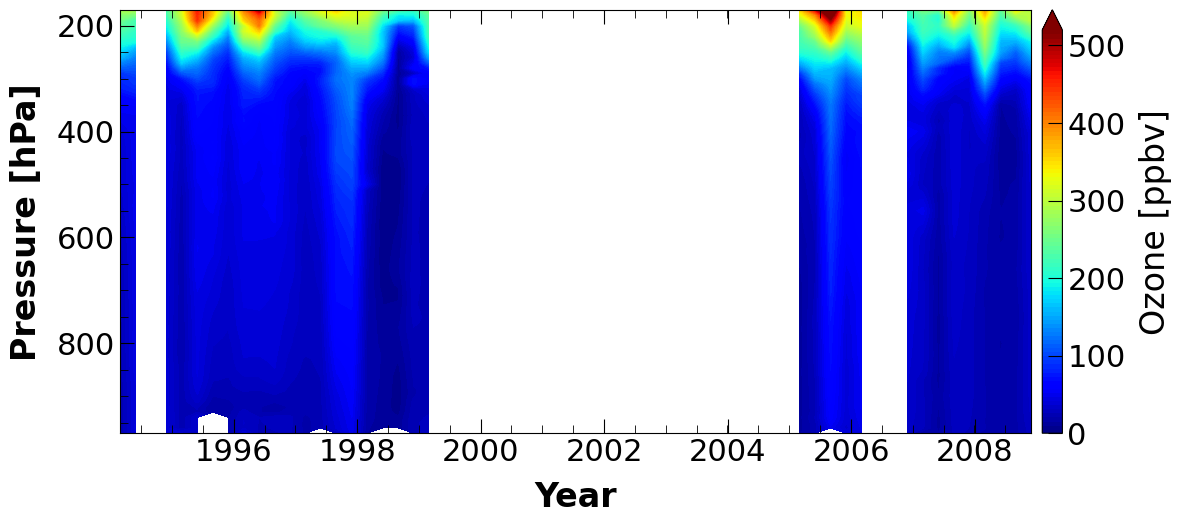

time: 1.96 s


In [4]:
levels = np.linspace(0, 520, 100)
fig, ax = plt.subplots(1, 1, figsize=(14, 5.5))
time, level = np.meshgrid(df.time, df.level)
im = ax.contourf(time, level, 1000*df, levels=levels, extend='max', cmap='jet')
# ax.plot(tph.index, tph)
cb = plt.colorbar(im, ticks=np.arange(0, 501, 100), pad=0.01)
cb.ax.set_ylabel('Ozone [ppbv]')
ax.set_ylabel('Pressure [hPa]', fontweight='bold')
ax.set_xlabel('Year', fontweight='bold')
ax.set_ylim([170, 970])
ax.minorticks_on()
ax.invert_yaxis()
plt.savefig('./figs/maitri.profile.tropo.png', bbox_inches='tight')
plt.savefig('./figs/maitri.profile.tropo.pdf', bbox_inches='tight')
plt.show()

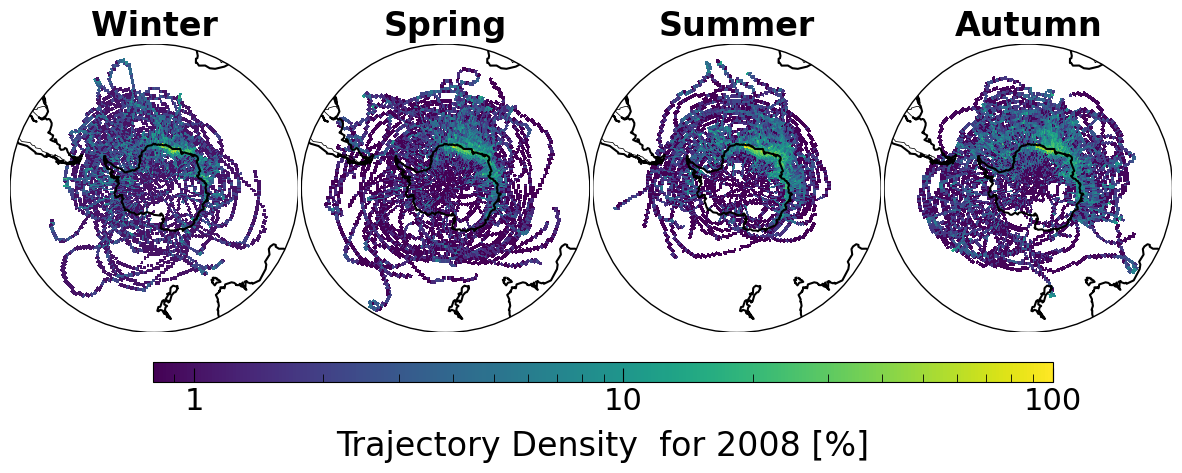

time: 5.56 s


In [5]:
cmap = 'viridis'
height = 500
year = 2008
seasons = {}
seasons['Winter'] = ('%s-06-01'%year, '%s-07-31'%year)
seasons['Spring'] = ('%s-09-01'%year, '%s-11-30'%year)
seasons['Summer'] = ('%s-12-01'%(year-1), '%s-02-29'%year)
seasons['Autumn'] = ('%s-03-01'%year, '%s-05-31'%year)

traj = xr.open_dataset('/home/pankaj/phd/code/airmass/data/gdas/%s.gdas.nc'%height)['myth']

fig, axes = plt.subplots(1, 4, figsize=(15, 4))
cax = fig.add_axes([0.22, 0.01, 0.6, 0.05])
for ax, season in zip(axes, list(seasons.keys())):
    s, e = seasons[season]
    trj = Trajectory(traj.sel(Date=slice(s, e)))
    h, m = trj.plot_density(ax=ax, normed=True, min_lat=-30, cmap=cmap)
    ax.set_title(season, fontweight='bold')
cb = plt.colorbar(h, cax=cax, orientation='horizontal')
cb.ax.set_xlabel('Trajectory Density  for ' + str(year) + ' [%]')
cb.ax.xaxis.set_major_formatter(ticker.FormatStrFormatter("%d"))
plt.subplots_adjust(wspace=0.01)
plt.savefig('./figs/traj.2008.%sm.png'%height, bbox_inches='tight')
plt.show()

In [6]:
df = dd.read_csv('/home/pankaj/phd/code/maitri/data/profile/*.csv', sep='\s+', assume_missing=True).compute()
df['Date'] = pd.to_datetime(df['Year'] * 10000 + df['Mon'] * 100 + df['Day'], format='%Y%m%d')
df = df[df.vmr<10]
df.index = df[['Press', 'Date']]
df.index = pd.MultiIndex.from_tuples(df.index)
df = df['vmr'].unstack(1).fillna(method='ffill').fillna(method='bfill')

time: 2.98 s


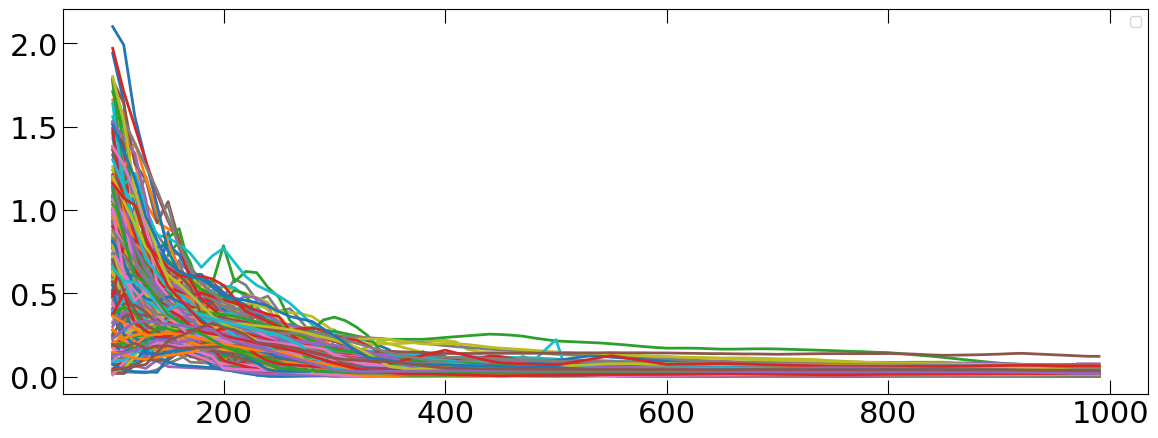

time: 902 ms


In [7]:
df.fillna(method='ffill').fillna(method='bfill').plot(figsize=(14, 5))
plt.legend('')
plt.show()

In [8]:
random.seed(9001)
data = df.T
som = sps.somNet(2, 2, data.values, PCI=True)
som.train(startLearnRate=0.01, epochs=100000)

Periodic Boundary Conditions inactive.
The weights will be initialised with PCA.
Training SOM... done!
time: 1min 31s


In [9]:
pos = som.project(data.values, printout=False)
num = 4
clusters = som.cluster(data.values, type='KMeans', \
                       numcl=num, show=False, printout=False)

labels = pd.Series(index=data.index, name='cluster')
for i, lebs in enumerate(clusters):
    for idx in lebs:
        labels.iloc[idx] = i

time: 274 ms


In [10]:
def group_count(df, freq='M'):
    if freq=='M':
        dx = df.groupby(df.index.month).count()
    elif freq=='Q':
        #dx = df.groupby(df.index.quarter).count()
        dx = df.resample('Q-NOV').count()
        dx = dx.groupby(dx.index.month).sum()
    else:
        dx = df.groupby(df.index.year).count()
    return dx       
    
def count_values(labels, freq='M', num=4):
    dfreq = pd.DataFrame()
    tot = group_count(labels, freq=freq)
    for clus in np.arange(num):
        dx = group_count(labels[labels==clus], freq=freq)
        dfreq = pd.concat([dfreq, dx/tot], axis=1)
    dfreq.columns = ['cluster' + str(i+1) for i in np.arange(num)]
    return dfreq

time: 2.65 ms


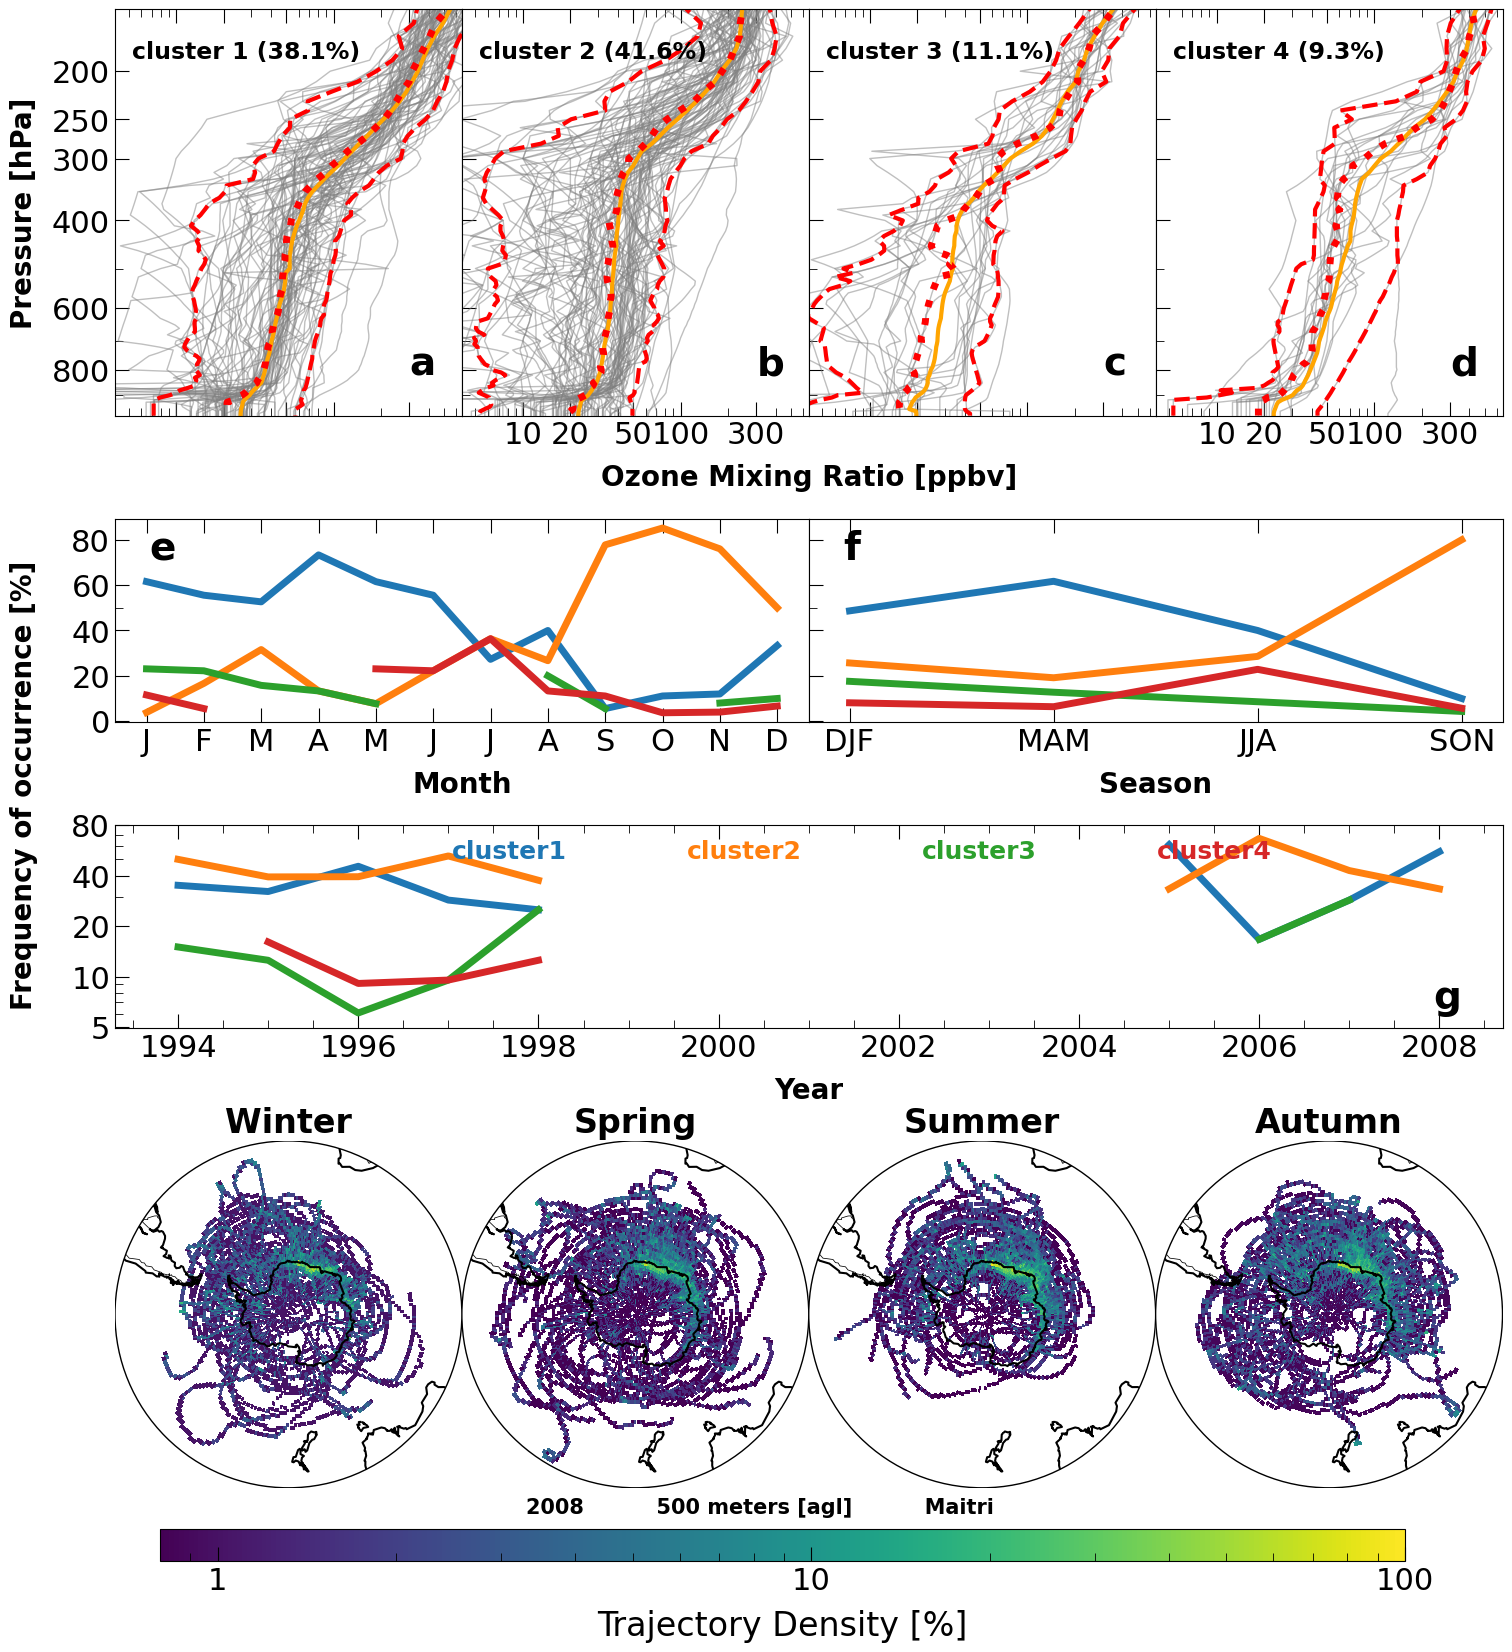

time: 20.9 s


In [11]:
size = 20
station = 'Maitri'
fig = plt.figure(figsize=(15, 16))
# gs = gridspec.GridSpec(4, 4, width_ratios=[1, 1, 1, 1], \
#                        height_ratios=[2, 1, 1.1],\
#                        hspace=0.25, wspace=0.0)

gs = gridspec.GridSpec(4, 4, width_ratios=[1, 1, 1, 1], \
                       height_ratios=[2, 1, 1, 1.8],\
                       hspace=0.35, wspace=0.0)
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1], sharey=ax1, sharex=ax1)
ax3 = plt.subplot(gs[0, 2], sharey=ax1, sharex=ax1)
ax4 = plt.subplot(gs[0, 3], sharey=ax1, sharex=ax1)
ax5 = plt.subplot(gs[1, 0:2])
ax6 = plt.subplot(gs[1, 2:], sharey=ax5)
ax7 = plt.subplot(gs[2, :])

axes = [ax1, ax2, ax3, ax4]
for ax in axes:
    ax.set_rasterized(True)
for idx, ax in enumerate(axes):
    oz = 1000*data.loc[labels==idx].T
    months = list(oz.T.index.month.value_counts().index)[:4]
    perc = 100.0*oz.T.count()[100]/data.count()[100]
    perc = round(perc, 1)
    m = ax.loglog(oz, oz.index, lw=1, color='grey', alpha=0.5)
    ax.plot(oz.mean(axis=1), oz.index, lw=3, color='orange')
    ax.plot(oz.median(axis=1), oz.index, lw=5, color='red', ls=':')
    ax.plot(oz.quantile(0.95, axis=1), oz.index, lw=3, color='red', ls='--')
    ax.plot(oz.quantile(0.05, axis=1), oz.index, lw=3, color='red', ls='--')
    #ax.axhline(grp.loc[idx, 'TPH'], ls='--', lw=1, color='blue')
    ax.text(0.05, 0.88, 'cluster '+ str(idx+1)+' ('+str(perc) + '%)', \
            transform=ax.transAxes, \
            fontsize=17, fontweight='bold')
#     ax.text(0.05, 0.85, 'TCO: ' + str(grp.loc[idx, 'TCO']) + ' DU' , \
#             transform=ax.transAxes, \
#             fontsize=17, fontweight='bold') 
# for ax in axes:
#     ax.set_rasterized(False)
ax1.set_xticks([10, 20, 50, 100, 300])
ax1.set_yticks([200, 250, 300, 400, 600, 800])
ax1.set_xlim([4.1, 650])
ax1.set_ylim([150, 990])
ax1.invert_yaxis()
# ax1.minorticks_on()
# ax1.yaxis.set_minor_formatter(ticker.FormatStrFormatter("%d"))
plt.setp(ax1.get_yminorticklabels(), visible=False)
for axis in [ax1.xaxis, ax1.yaxis]:
    axis.set_major_formatter(ticker.FormatStrFormatter("%d"))  
for ax in axes[1:]:
    plt.setp(ax.get_ymajorticklabels(), visible=False)
    plt.setp(ax.get_yminorticklabels(), visible=False)
ax1.set_ylabel('Pressure [hPa]', fontsize=size, fontweight='bold')  
ax2.set_xlabel('Ozone Mixing Ratio [ppbv]', x=1.0, fontsize=size, fontweight='bold')

#ax5.plot(100*count_values(labels, freq='M'), lw=5)
st = 100*count_values(labels, freq='M')
ax5.plot(np.arange(len(st))+1, st, lw=5)
ax5.set_xticks(np.arange(1, 13, 1))
ax5.set_xticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S','O',  'N', 'D'])
ax5.set_yticks([0, 20, 40, 60, 80])
# ax5.minorticks_on()
# ax5.xaxis.set_tick_params(which='minor', bottom=False)

# (100*count_values(labels, freq='Q')).plot(ax=ax6, lw=5, legend=False)
# ax6.plot(100*count_values(labels, freq='Q'), lw=5)
st = 100*count_values(labels, freq='Q')
ax6.plot(np.arange(len(st))+1, st, lw=5)
ax6.set_xlim([0.8, 4.2])
ax6.set_xticks([1, 2, 3, 4])
ax6.set_xticklabels(['DJF', 'MAM', 'JJA', 'SON'])
plt.setp(ax6.get_ymajorticklabels(), visible=False)

#ax7.semilogy(100*count_values(labels, freq='A').dropna(), lw=3)
tmp = 100*count_values(labels, freq='A')
tmp1 = pd.DataFrame(columns=tmp.columns, index=np.arange(1994, 2009))
for idx in tmp1.index:
    try:
        tmp1.loc[idx, :] = tmp.loc[idx, :]
    except:
        pass
tmp1.plot(ax=ax7, lw=5, logy=True)
ax7.set_yticks([5, 10, 20, 40, 80])
ax7.yaxis.set_major_formatter(ticker.FormatStrFormatter("%d"))
ax5.set_xlabel('Month', fontsize=size, fontweight='bold')
ax6.set_xlabel('Season', fontsize=size, fontweight='bold')
ax7.set_xlabel('Year', fontsize=size, fontweight='bold')
ax7.set_ylabel('Frequency of occurrence [%]', y=1.2, fontsize=size, fontweight='bold')

plt.setp(ax1.get_xmajorticklabels(), visible=True)
plt.setp(ax3.get_xmajorticklabels(), visible=True)

handles, legends  = ax7.get_legend_handles_labels()
leg = ax7.legend(handles, legends, loc=1, frameon=False, bbox_to_anchor=(0.85,1.04), \
                 prop={'weight':'bold', 'size':18}, ncol=4)
color_legend_texts(leg)
ax7.minorticks_on()
fig.align_ylabels()

ax8 = plt.subplot(gs[3, 0])
ax9 = plt.subplot(gs[3, 1])
ax10 = plt.subplot(gs[3, 2])
ax11 = plt.subplot(gs[3, 3])
axes = [ax8, ax9, ax10, ax11]
cax = fig.add_axes([0.1, 0.01, 0.83, 0.02])
for ax, season in zip(axes, list(seasons.keys())):
    s, e = seasons[season]
    trj = Trajectory(traj.sel(Date=slice(s, e)))
    h, m = trj.plot_density(ax=ax, normed=True, min_lat=-30, cmap=cmap)
    ax.set_title(season, fontweight='bold')
    
cb = plt.colorbar(h, cax=cax, orientation='horizontal')
cb.ax.set_xlabel('Trajectory Density [%]')
cb.ax.xaxis.set_major_formatter(ticker.FormatStrFormatter("%d"))
txt = str(year)+ '          ' + str(height) + ' meters [agl]'+ '          '  + station
fig.suptitle(txt, fontsize = 15, fontweight = 'bold', x=0.5, y=0.05)
for ax in axes:
    ax.set_rasterized(True)

axes = [ax1, ax2, ax3, ax4, ax5, ax6, ax7]
for i, ax in enumerate(axes):    
    if ax==ax7:
        ax.text(0.95, 0.1, alphabets[i], fontsize=28, fontweight='bold', \
            color='black', transform=ax.transAxes)
    elif ax in [ax5, ax6]:
        ax.text(0.05, 0.8, alphabets[i], fontsize=28, fontweight='bold', \
            color='black', transform=ax.transAxes)
    else:
        ax.text(0.85, 0.1, alphabets[i], fontsize=28, fontweight='bold', \
            color='black', transform=ax.transAxes)
plt.subplots_adjust(top=0.98, bottom=0.05, left=0.07, right=0.995)
plt.savefig('./figs/cluster.ozone.profile.png', bbox_inches='tight')
plt.savefig('./figs/cluster.ozone.profile.eps', bbox_inches='tight')
plt.savefig('./figs/cluster.ozone.profile.pdf', bbox_inches='tight')
plt.show()